In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

In [42]:
cutdown_rows = 0

LABEL = 'Price'

floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms',
          'nearestStation', 'nearestTram', 'nearestUnderground', 'nearestOverground',
          ]

categories = ['tenure.tenureType',
              'analyticsProperty.soldSTC',
              'analyticsProperty.preOwned',
              'sharedOwnership.sharedOwnership',
              'analyticsProperty.propertyType',  # 'propertyType',
              #'analyticsProperty.propertySubType',
              #'borough',
              #'analyticsProperty.priceQualifier'
              ]
categories = []

features = floats.copy()
features.extend(categories)
features.insert(0, LABEL)
features

['Price',
 'location.latitude',
 'location.longitude',
 'bedrooms',
 'bathrooms',
 'nearestStation',
 'nearestTram',
 'nearestUnderground',
 'nearestOverground']

In [43]:
def get_source_dataframe(rows=cutdown_rows):
    df = pd.read_csv('../data/source/df_listings.csv', on_bad_lines='skip', index_col=0)
    df = df[features]

    if rows and rows > 0:
        df = df[:rows]
    return df


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.7, random_state=1)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.7, random_state=1)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        #X_train1 = X_train1[:,3:]
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        #X_test1 = X_test1[:,3:]
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        # X_train_index = pd.to_numeric(X_train_index, 'coerce').astype(int)
        # y_train_index = pd.to_numeric(y_train_index, 'coerce').astype(int)
        # X_test_index = pd.to_numeric(X_test_index, 'coerce').astype(int)
        # y_test_index = pd.to_numeric(y_test_index, 'coerce').astype(int)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index


X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(
    get_source_dataframe(), return_index=True, drop_nulls=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape, X_train_index

((18643, 8),
 (7990, 8),
 (18643, 1),
 (7990, 1),
 (18643, 1),
 (7990, 1),
 (18643, 1),
 (7990, 1),
 array([[9.65746780e+07],
        [8.53987200e+07],
        [8.57140740e+07],
        ...,
        [8.56446690e+07],
        [1.15593302e+08],
        [7.35063450e+07]]))

In [44]:
df = get_source_dataframe()
print(df.shape)
df[:5]

(26633, 9)


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground
14520525,550000,51.529950,-0.207020,3.0,1.0,0.274316,NaN,0.274316,0.274316
27953107,400000,51.549390,-0.482600,2.0,2.0,0.305845,NaN,0.305845,NaN
33593487,579950,51.447180,-0.338770,2.0,1.0,0.438045,NaN,NaN,0.438045
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,NaN,0.399307,0.704048
35429088,599950,51.577030,-0.141230,2.0,1.0,0.238187,NaN,0.238187,1.054653


In [45]:
if 'nearestTram' in features:
    df['nearestTram'] = df['nearestTram'].fillna(99)
    df['nearestOverground'] = df['nearestOverground'].fillna(99)
    df['nearestUnderground'] = df['nearestUnderground'].fillna(99)
    df['nearestStation'] = df['nearestStation'].fillna(99)

    imputer = SimpleImputer(strategy='constant', fill_value=99)
    imputer.fit(df['nearestTram'].values.reshape(-1, 1))
    df['nearestTram'] = imputer.transform(df['nearestTram'].values.reshape(-1, 1))
    df['nearestUnderground'] = imputer.transform(df['nearestUnderground'].values.reshape(-1, 1))
    df['nearestOverground'] = imputer.transform(df['nearestOverground'].values.reshape(-1, 1))
    df['nearestStation'] = imputer.transform(df['nearestStation'].values.reshape(-1, 1))


if 'analyticsProperty.priceQualifier' in features:
    #df['shared_ownership'] = ((df['sharedOwnership.sharedOwnership'] == True) | (df['analyticsProperty.priceQualifier'] == 'Shared ownership'))
    df.drop(['analyticsProperty.priceQualifier'], axis=1, inplace=True)


df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground
14520525,550000,51.529950,-0.207020,3.0,1.0,0.274316,99.000000,0.274316,0.274316
27953107,400000,51.549390,-0.482600,2.0,2.0,0.305845,99.000000,0.305845,99.000000
33593487,579950,51.447180,-0.338770,2.0,1.0,0.438045,99.000000,99.000000,0.438045
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,99.000000,0.399307,0.704048
35429088,599950,51.577030,-0.141230,2.0,1.0,0.238187,99.000000,0.238187,1.054653
...,...,...,...,...,...,...,...,...,...
121677479,450000,51.483748,-0.388508,3.0,2.0,0.709062,99.000000,0.709062,99.000000
121677749,300000,51.532990,0.036340,2.0,1.0,0.178077,99.000000,0.178077,99.000000
121678004,475000,51.393990,0.045193,2.0,2.0,0.444410,99.000000,99.000000,0.444410
121678103,200000,51.410742,-0.225795,NaN,1.0,0.205738,0.917064,99.000000,0.205738


In [46]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)
#X_train[:5]


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#X_train_index
y_test

(16856, 8) (7225, 8) (16856, 1) (7225, 1) (16856, 1) (7225, 1) (16856, 1) (7225, 1)


array([[275000],
       [400000],
       [350000],
       ...,
       [400000],
       [425000],
       [540000]])

In [47]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [48]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        #layers.Dense(132, activation='relu'),
        #layers.Dense(132, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


normalizer = tf.keras.layers.Normalization(axis=-1)

dnn_model = build_and_compile_model(normalizer)

# % % time
history = dnn_model.fit(
    X_train,  # train_features,
    y_train,  # train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

print(dnn_model.evaluate(X_test, y_test, verbose=0))

model = dnn_model

2.10.0
75986.484375


In [49]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 8) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
normalization_2 (None, 8) float32
dense_6 (None, 8) float32
dense_7 (None, 64) float32
dense_8 (None, 64) float32


[None, None, None, None]

In [50]:
if False:
    pipe = Pipeline(steps=[
        ('preprocessor', features_preprocessor),  # preprocess features
        ('estimator', dnn_model),
    ])  # start the training

    params = {}
    grid = GridSearchCV(pipe, param_grid=params, cv=3, n_jobs=1, verbose=1, scoring='neg_mean_absolute_error')
    #grid.fit(X_train, y_train)
    #pipe.fit(X_train, y_train)
    history = pipe.fit(
        X_train,  # train_features,
        y_train,  # train_labels,
        validation_split=0.2,
        verbose=0, epochs=100)

    print("\nBest Score\n", grid.best_score_)
    best_estimator_pipe = grid.best_estimator_


In [51]:
result = model.predict(X_test)

226/226 [==============================] - 1s 2ms/step


In [52]:
print(result)

[[389278.94]
 [429542.  ]
 [320425.88]
 ...
 [397844.94]
 [388206.62]
 [383109.6 ]]


In [53]:
print(y_test_index.reshape((-1, 1)).shape)
print(result.reshape((-1, 1)).shape)
print(y_test.shape)

print(y_test_index.shape)
print(result.shape)
print(y_test.shape)

(7225, 1)
(7225, 1)
(7225, 1)
(7225, 1)
(7225, 1)
(7225, 1)


In [54]:
from pandas import DataFrame

compare = np.hstack((y_test_index, y_test, result))
#compare[0:4]

In [55]:
import math

compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
#compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %
reference,,,,
117084449,275000.0,389278.93750,114278.93750,41.555977
119863076,400000.0,429542.00000,29542.00000,7.385500
121635962,350000.0,320425.87500,29574.12500,8.449750
85349784,465000.0,418564.43750,46435.56250,9.986142
85778946,600000.0,460270.18750,139729.81250,23.288302
...,...,...,...,...
121469246,415000.0,491533.50000,76533.50000,18.441807
119227655,400000.0,385026.31250,14973.68750,3.743422
115256372,400000.0,397844.93750,2155.06250,0.538766


In [56]:
compare_df.join(df)

,actual,predicted,difference,diff 1 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,nearestTram,nearestUnderground,nearestOverground
reference,,,,,,,,,,,,,
117084449,275000.0,389278.93750,114278.93750,41.555977,275000,51.446195,-0.018447,2.0,1.0,0.305286,99.0,99.000000,0.305286
119863076,400000.0,429542.00000,29542.00000,7.385500,400000,51.563733,-0.456680,2.0,1.0,0.641872,99.0,0.641872,0.903916
121635962,350000.0,320425.87500,29574.12500,8.449750,350000,51.611246,-0.002896,1.0,1.0,0.232549,99.0,99.000000,0.232549
85349784,465000.0,418564.43750,46435.56250,9.986142,465000,51.496665,-0.083362,2.0,1.0,0.546365,99.0,0.546365,0.589599
85778946,600000.0,460270.18750,139729.81250,23.288302,600000,51.372820,-0.301380,3.0,1.0,0.599188,99.0,99.000000,0.599188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121469246,415000.0,491533.50000,76533.50000,18.441807,415000,51.568815,-0.438663,2.0,2.0,0.061833,99.0,0.061833,0.061833
119227655,400000.0,385026.31250,14973.68750,3.743422,400000,51.564617,-0.047707,2.0,1.0,0.456843,99.0,99.000000,0.456843
115256372,400000.0,397844.93750,2155.06250,0.538766,400000,51.324511,-0.135183,2.0,1.0,0.187759,99.0,99.000000,0.187759


In [57]:
if False:
    model.score(X_test, y_test)

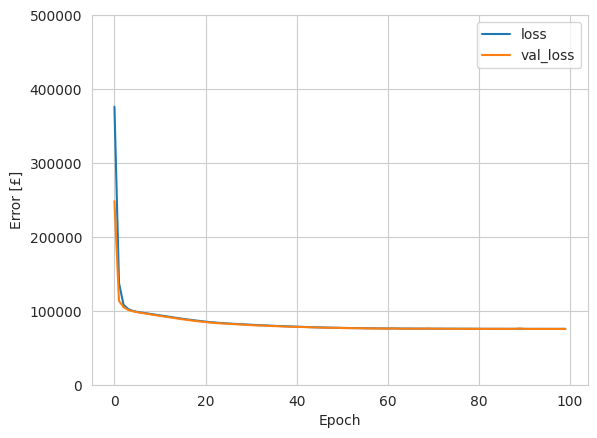

In [58]:
def plot_loss(history):
    import matplotlib.pyplot as plt

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 500000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [£]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [59]:
print(", ".join([str(x) for x in history.history["loss"][:5]]))
print('...')
print(", ".join([str(x) for x in history.history["loss"][-5:]]))

376097.96875, 137470.578125, 108072.4453125, 102431.640625, 99911.1640625
...
75557.5859375, 75575.9609375, 75537.5, 75568.359375, 75592.8203125


In [60]:

#test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
dnn_model.evaluate(X_test, y_test, verbose=0)


75986.484375